In [4]:
import pandas as pd
import time
import numpy as np
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem import WordNetLemmatizer
import os
from matplotlib import pyplot as plt

In [5]:
df = pd.read_csv('../01-data-collection/hate_speech.csv',index_col=0)
df.sample(n=5)

,user_id,label,text,hashtag,id,location,follower_count,friends_count,country,retweet_count,favorite_count
1519,574296209394827265,none,@elplatt i'm mostly pondering a few startup in...,NaN,13857342,"Portland, OR",19170,797,NaN,0,1
1089,433412449971081216,none,Here's my review of 99% of games I've ever pla...,NaN,930620467,NaN,19820,258,NaN,2,4
767,508800404269043712,none,I am sterile. #ThreeWordsSheWantsToHear,ThreeWordsSheWantsToHear,930620467,NaN,19819,258,NaN,2,3
2493,504674884380016640,none,@diesel_frost but since most of the victims ar...,NaN,930620467,NaN,19819,258,NaN,0,0
386,563780337549844480,none,@ncweaver i'm glad California is finally getti...,NaN,13857342,"Portland, OR",19170,797,NaN,0,0


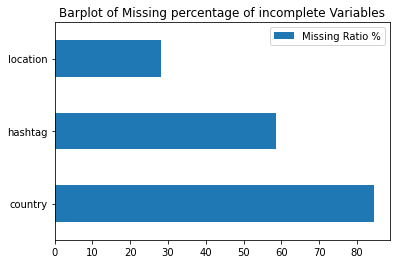

In [6]:
def plot_nas(trainData: pd.DataFrame):
    if trainData.isnull().sum().sum() != 0:
        na_df = (trainData.isnull().sum() / len(trainData)) * 100      
        na_df = na_df.drop(na_df[na_df == 0].index).sort_values(ascending=False)
        missing_data = pd.DataFrame({'Missing Ratio %' :na_df})
        missing_data.plot(kind = "barh")
        plt.title('Barplot of Missing percentage of incomplete Variables')
        plt.show()
    else:
        print('No NAs found')
plot_nas(df)

In [7]:
df.drop(columns=['user_id','country'],inplace=True)
df.label.unique()

array(['none', 'sexism'], dtype=object)

In [8]:
map = {'none':0,
        'sexism':'1',
        }
df.label = df.label.map(map)

In [9]:
df = df[~df.text.str.contains('RT')].copy()
df.shape

(1252, 9)

In [10]:
#remove contractions
def decontract(text):
    text = re.sub(r"can\'t", "can not", text)
    text = re.sub(r"n\'t", " not", text)
    text = re.sub(r"\'re", " are", text)
    text = re.sub(r"\'s", " is", text)
    text = re.sub(r"\'d", " would", text)
    text = re.sub(r"\'ll", " will", text)
    text = re.sub(r"\'t", " not", text)
    text = re.sub(r"\'ve", " have", text)
    text = re.sub(r"\'m", " am", text)
    return text
#1.build lemmatize models, and stopwords dictionary
stopwords = stopwords.words('English')
# the pipeline to process the raw text data
def pipeline(text:str):
    lm = WordNetLemmatizer()
    text = text.lower()
    # remove the hashtags and remove all the mentions@
    text = ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)"," ",text).split())
    text=re.sub("\\W"," ",text) # remove special chars
    str_input = re.sub(pattern=r'[^a-zA-z]',repl=' ',string=text) #remove words except digit and words
#     str_output = correct_sentence_spelling(sentence = str_input) # it is too time-consuming
    token_list = word_tokenize(str_input)
    token_list = [lm.lemmatize(i) for i in token_list]
    word_list = [word for word in token_list if word not in stopwords]
    word_str = ' '.join(word_list)
    return word_str
def preprocess(text):
    # text = strip_emoji(text)
    text = decontract(text)
    text = pipeline(text)
    return text

In [11]:
texts_cleaned = []
for t in df.text:
    texts_cleaned.append(preprocess(t))
df.loc[:,'texts_cleaned'] = np.array(texts_cleaned)
df.head()

,label,text,hashtag,id,location,follower_count,friends_count,retweet_count,favorite_count,texts_cleaned
1,0,Because if Elliot Rodger had killed just ONE w...,YesAllWomen,930620467,NaN,19820,258,19,17,elliot rodger killed one woman rejected date w...
4,0,@Grummz @rxptor @Spacekatgal @TheQuinnspiracy ...,NaN,13857342,"Portland, OR",19172,797,0,2,keep mind volume volume vitriol disproportiona...
8,0,My face every time I hear or see Kat....hope i...,mkr,482583016,NaN,59,39,0,3,face every time hear see kat hope get stuck mkr
10,0,Empathy is the social skill that informs all o...,NaN,930620467,NaN,19820,258,1,0,empathy social skill informs others specie wit...
11,0,"@tmclaughbos yo, are you going to #bsdcan? @bs...",bsdcan,13857342,"Portland, OR",19170,797,0,1,yo going bsdcan going could cause trouble p


In [13]:
df.loc[:,'word_length'] = df.texts_cleaned.apply(lambda x:len(x.split(' ')))

In [14]:
df_output = df.loc[:,['id','location','follower_count','friends_count','retweet_count','favorite_count','texts_cleaned','word_length','label']]
df_output.rename(columns={'texts_cleaned':'text'},inplace=True)
df_output.head()

,id,location,follower_count,friends_count,retweet_count,favorite_count,text,word_length,label
1,930620467,NaN,19820,258,19,17,elliot rodger killed one woman rejected date w...,11,0
4,13857342,"Portland, OR",19172,797,0,2,keep mind volume volume vitriol disproportiona...,8,0
8,482583016,NaN,59,39,0,3,face every time hear see kat hope get stuck mkr,10,0
10,930620467,NaN,19820,258,1,0,empathy social skill informs others specie wit...,11,0
11,13857342,"Portland, OR",19170,797,0,1,yo going bsdcan going could cause trouble p,8,0


In [17]:
df_output.shape

(1252, 9)

In [18]:
df_output = df_output[~df_output['text'].isnull()]
df_output.reset_index(drop=True,inplace=True)


In [19]:
df_output.to_csv('../../data/hate_speech.csv')